### **User Segmentation and Recommendation Prediction for Mobile Money Services**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [6]:
# Load data
df = pd.read_excel("/content/Mobile_Money.xlsx")

# Check structure
print(df.shape)
print(df.head())
print(df.info())


(104, 62)
     ID      Age  Gender      Job Uses_MM Freq_Use Weekly_Amt     Trust_Level  \
0  P001  15 - 24  Female  Student     Yes    Daily   Below 25  Strongly trust   
1  P002  15 - 24    Male  Student     Yes    Daily   Below 25  Strongly trust   
2  P003  25 - 45  Female  Student     Yes    Daily   25 - 100         Neutral   
3  P005  15 - 24    Male  Student     Yes    Daily   Below 25  Somewhat trust   
4  P006  15 - 24    Male  Student     Yes    Daily   25 - 100  Strongly trust   

  Had_Issues       Sec_Aware  ... Motive_LowFees Motive_SaveLoan  \
0         No  Somewhat trust  ...              0               1   
1         No             Yes  ...              0               0   
2        Yes  Somewhat trust  ...              0               0   
3        Yes             Yes  ...              0               0   
4         No             Yes  ...              0               0   

  Motive_Security  Motive_Agents  Motive_Trust  Motive_WideAcc  Motive_Promos  \
0            

In [7]:
features = [
    'Freq_Use', 'Weekly_Amt',
    'Trust_Level', 'Recommend_MM', 'Had_Issues', 'Sec_Aware',
    'Use_Send', 'Use_Receive', 'Use_TopUp', 'Use_LoanRepay', 'Use_DailyNeeds', 'Use_Bills', 'Use_Shop', 'Use_Salary',
    'Motive_LowFees', 'Motive_Security', 'Motive_Trust', 'Motive_Promos', 'Motive_WideAcc', 'Motive_NoCash'
]


In [8]:
df_cluster = df[features].copy()
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Freq_Use         104 non-null    object
 1   Weekly_Amt       104 non-null    object
 2   Trust_Level      104 non-null    object
 3   Recommend_MM     104 non-null    object
 4   Had_Issues       104 non-null    object
 5   Sec_Aware        104 non-null    object
 6   Use_Send         104 non-null    int64 
 7   Use_Receive      104 non-null    int64 
 8   Use_TopUp        104 non-null    int64 
 9   Use_LoanRepay    104 non-null    int64 
 10  Use_DailyNeeds   104 non-null    int64 
 11  Use_Bills        104 non-null    int64 
 12  Use_Shop         104 non-null    int64 
 13  Use_Salary       104 non-null    int64 
 14  Motive_LowFees   104 non-null    int64 
 15  Motive_Security  104 non-null    int64 
 16  Motive_Trust     104 non-null    int64 
 17  Motive_Promos    104 non-null    in

In [9]:
for col in df_cluster.columns:
    if df_cluster[col].dtype == 'object':
        print(f"{col}: {df_cluster[col].unique()}")


Freq_Use: ['Daily' 'A few times a week' 'Rarely' 'Once a week' 'A few times a month']
Weekly_Amt: ['Below 25' '25 - 100' 'Over 300' '100–300']
Trust_Level: ['Strongly trust' 'Neutral' 'Somewhat trust']
Recommend_MM: ['Yes' 'Maybe' 'No' 'Not sure']
Had_Issues: ['No' 'Yes']
Sec_Aware: ['Somewhat trust' 'Yes' 'No']


In [10]:
# Map frequency of use to numeric scale (higher = more frequent)
freq_map = {
    'Rarely': 0,
    'A few times a month': 1,
    'Once a week': 2,
    'A few times a week': 3,
    'Daily': 4
}

# Map spending amount (higher = more spending)
amt_map = {
    'Below 25': 1,
    '25 - 100': 2,
    '100–300': 3,
    'Over 300': 4
}

# Trust levels
trust_map = {
    'Neutral': 1,
    'Somewhat trust': 2,
    'Strongly trust': 3
}

# Yes/No/Maybe/Not sure type
recommend_map = {
    'No': 0,
    'Not sure': 1,
    'Maybe': 2,
    'Yes': 3
}

# Had issues: binary
issues_map = {
    'No': 0,
    'Yes': 1
}

# Sec_Aware seems mixed (yes/no + trust), so general mapping:
sec_aware_map = {
    'No': 0,
    'Somewhat trust': 1,
    'Yes': 2
}

# Apply mappings
df_cluster['Freq_Use'] = df_cluster['Freq_Use'].map(freq_map)
df_cluster['Weekly_Amt'] = df_cluster['Weekly_Amt'].map(amt_map)
df_cluster['Trust_Level'] = df_cluster['Trust_Level'].map(trust_map)
df_cluster['Recommend_MM'] = df_cluster['Recommend_MM'].map(recommend_map)
df_cluster['Had_Issues'] = df_cluster['Had_Issues'].map(issues_map)
df_cluster['Sec_Aware'] = df_cluster['Sec_Aware'].map(sec_aware_map)

# Final check
print(df_cluster.info())
print(df_cluster.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Freq_Use         104 non-null    int64
 1   Weekly_Amt       104 non-null    int64
 2   Trust_Level      104 non-null    int64
 3   Recommend_MM     104 non-null    int64
 4   Had_Issues       104 non-null    int64
 5   Sec_Aware        104 non-null    int64
 6   Use_Send         104 non-null    int64
 7   Use_Receive      104 non-null    int64
 8   Use_TopUp        104 non-null    int64
 9   Use_LoanRepay    104 non-null    int64
 10  Use_DailyNeeds   104 non-null    int64
 11  Use_Bills        104 non-null    int64
 12  Use_Shop         104 non-null    int64
 13  Use_Salary       104 non-null    int64
 14  Motive_LowFees   104 non-null    int64
 15  Motive_Security  104 non-null    int64
 16  Motive_Trust     104 non-null    int64
 17  Motive_Promos    104 non-null    int64
 18  Motive_Wid

In [11]:
# Step 1: Check the variance of each column
variances = df_cluster.var()

# Step 2: Display variance values
print("=== Variance of Features ===")
print(variances.sort_values())

# Step 3: (Optional) Highlight features with low variance (e.g. < 0.01)
low_variance = variances[variances < 0.01]
print("\n=== Low-Variance Features (may be dropped) ===")
print(low_variance)


=== Variance of Features ===
Motive_NoCash      0.071695
Use_LoanRepay      0.079817
Motive_Trust       0.168409
Use_Send           0.179238
Use_DailyNeeds     0.189320
Motive_Promos      0.189320
Use_TopUp          0.207244
Use_Salary         0.225448
Motive_WideAcc     0.228529
Use_Receive        0.231423
Use_Bills          0.238984
Motive_Security    0.249066
Had_Issues         0.249066
Use_Shop           0.250093
Motive_LowFees     0.250093
Trust_Level        0.474608
Sec_Aware          0.508495
Recommend_MM       0.737864
Weekly_Amt         0.761763
Freq_Use           0.804238
dtype: float64

=== Low-Variance Features (may be dropped) ===
Series([], dtype: float64)


In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)


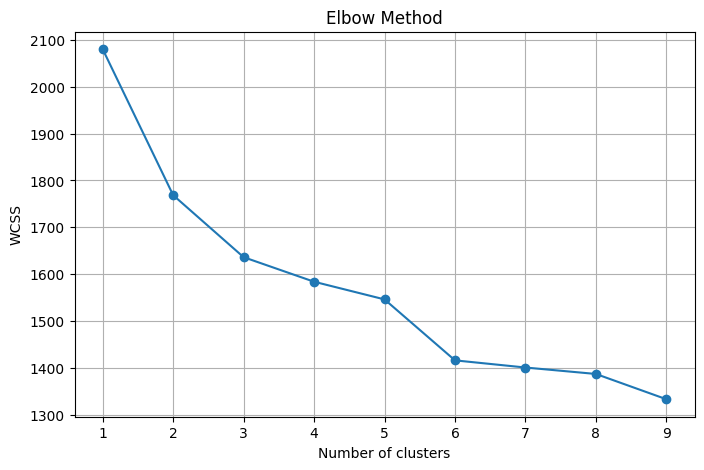

In [13]:
wcss = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot
plt.figure(figsize=(8,5))
plt.plot(range(1, 10), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()


In [14]:
kmeans = KMeans(n_clusters=2, random_state=42)
df_cluster['Cluster'] = kmeans.fit_predict(X_scaled)


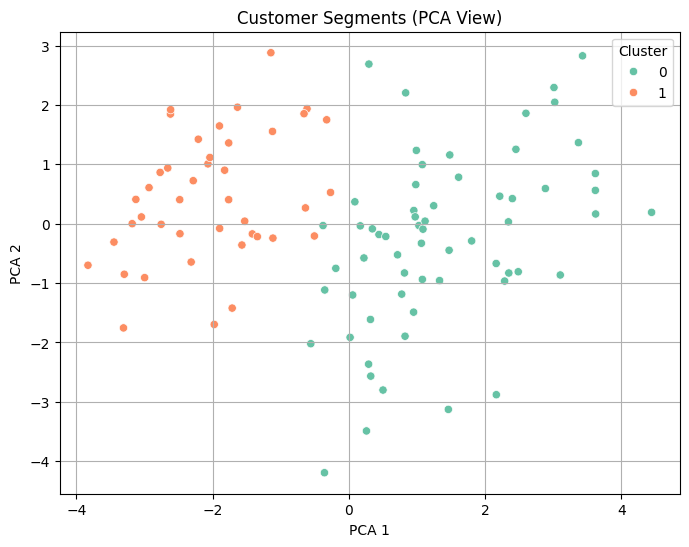

In [15]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_cluster['Cluster'], palette='Set2')
plt.title('Customer Segments (PCA View)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()


In [16]:
# See the average values for each feature per cluster
summary = df_cluster.groupby('Cluster').mean()
print(summary)


         Freq_Use  Weekly_Amt  Trust_Level  Recommend_MM  Had_Issues  \
Cluster                                                                
0        3.741935    1.919355     2.209677      2.612903    0.661290   
1        3.404762    1.452381     2.119048      2.333333    0.404762   

         Sec_Aware  Use_Send  Use_Receive  Use_TopUp  Use_LoanRepay  \
Cluster                                                               
0         1.338710  1.000000     0.935484   0.983871       0.145161   
1         1.428571  0.428571     0.214286   0.309524       0.000000   

         Use_DailyNeeds  Use_Bills  Use_Shop  Use_Salary  Motive_LowFees  \
Cluster                                                                    
0              0.290323   0.516129  0.822581    0.532258        0.629032   
1              0.190476   0.190476  0.142857    0.047619        0.428571   

         Motive_Security  Motive_Trust  Motive_Promos  Motive_WideAcc  \
Cluster                                         

In [17]:
print(df_cluster['Cluster'].value_counts())


Cluster
0    62
1    42
Name: count, dtype: int64


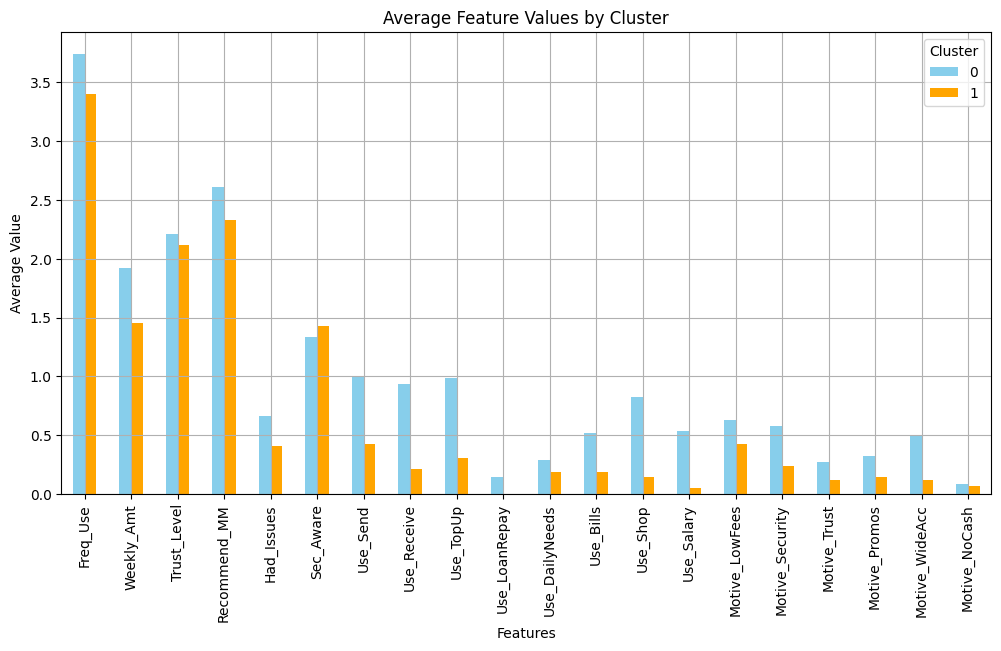

In [18]:
import matplotlib.pyplot as plt

# Define colors for each cluster
colors = ['skyblue', 'orange']  # Cluster 0 will be skyblue, Cluster 1 orange

summary.T.plot(kind='bar', figsize=(12, 6), color=colors)

plt.title('Average Feature Values by Cluster')
plt.ylabel('Average Value')
plt.xlabel('Features')
plt.grid(True)
plt.show()



In [19]:
# Radar chart (optional but looks great)
import plotly.express as px
cluster_summary = df_cluster.groupby('Cluster').mean().reset_index()
px.line_polar(cluster_summary.melt(id_vars='Cluster'),
              r='value', theta='variable',
              color='Cluster', line_close=True,
              title='Cluster Comparison').show()



In [20]:
from sklearn.metrics import silhouette_score

for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"k={k}, Silhouette Score = {score:.3f}")



k=2, Silhouette Score = 0.133
k=3, Silhouette Score = 0.109
k=4, Silhouette Score = 0.085
k=5, Silhouette Score = 0.082
k=6, Silhouette Score = 0.107


In [21]:
df_cluster['Cluster'] = KMeans(n_clusters=2, random_state=42).fit_predict(X_scaled)
cluster_summary = df_cluster.groupby('Cluster').mean()
print(cluster_summary)


         Freq_Use  Weekly_Amt  Trust_Level  Recommend_MM  Had_Issues  \
Cluster                                                                
0        3.741935    1.919355     2.209677      2.612903    0.661290   
1        3.404762    1.452381     2.119048      2.333333    0.404762   

         Sec_Aware  Use_Send  Use_Receive  Use_TopUp  Use_LoanRepay  \
Cluster                                                               
0         1.338710  1.000000     0.935484   0.983871       0.145161   
1         1.428571  0.428571     0.214286   0.309524       0.000000   

         Use_DailyNeeds  Use_Bills  Use_Shop  Use_Salary  Motive_LowFees  \
Cluster                                                                    
0              0.290323   0.516129  0.822581    0.532258        0.629032   
1              0.190476   0.190476  0.142857    0.047619        0.428571   

         Motive_Security  Motive_Trust  Motive_Promos  Motive_WideAcc  \
Cluster                                         

/tmp/ipython-input-701401801.py:19: UserWarning:

Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.



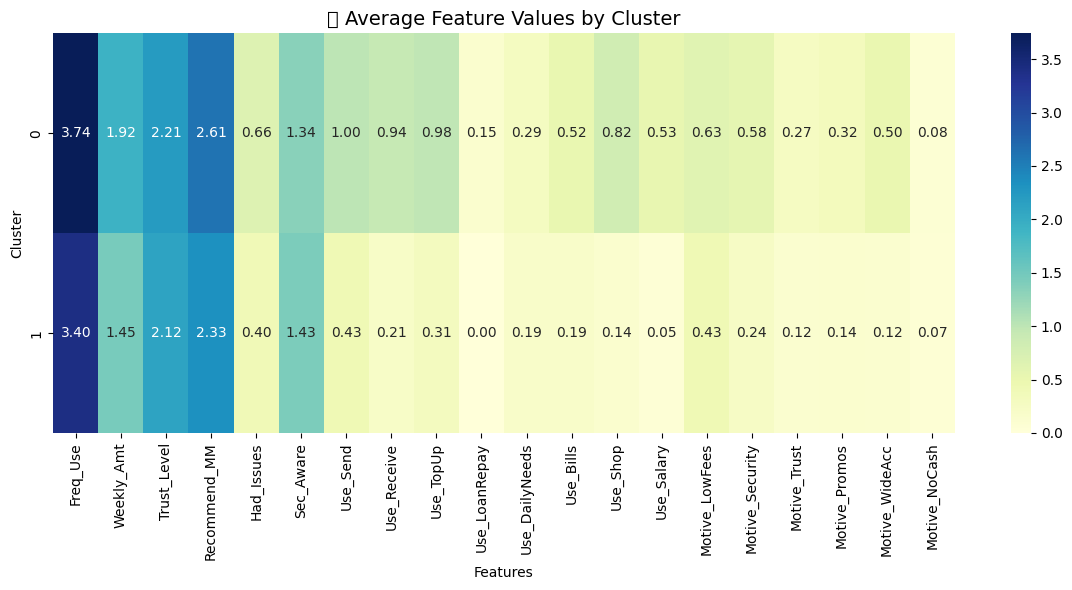

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group data by cluster and calculate the mean of each feature
cluster_summary = df_cluster.groupby('Cluster').mean()

# Set the size of the plot
plt.figure(figsize=(12, 6))

# Create a heatmap
sns.heatmap(cluster_summary, cmap="YlGnBu", annot=True, fmt=".2f")

# Set title
plt.title("🔍 Average Feature Values by Cluster", fontsize=14)
plt.xlabel("Features")
plt.ylabel("Cluster")

# Show the plot
plt.tight_layout()
plt.show()


### **Integrating Unsupervised Clustering and Multinomial Logistic Regression for Predicting User Recommendations in Mobile Money Systems**

Original class distribution:
 Recommend_MM
3    71
2    20
1     7
0     6
Name: count, dtype: int64

Resampled class distribution:
 Counter({3: 71, 2: 71, 0: 71, 1: 71})

Accuracy: 0.9824561403508771

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        14
           2       0.94      1.00      0.97        15
           3       1.00      0.93      0.96        14

    accuracy                           0.98        57
   macro avg       0.98      0.98      0.98        57
weighted avg       0.98      0.98      0.98        57



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



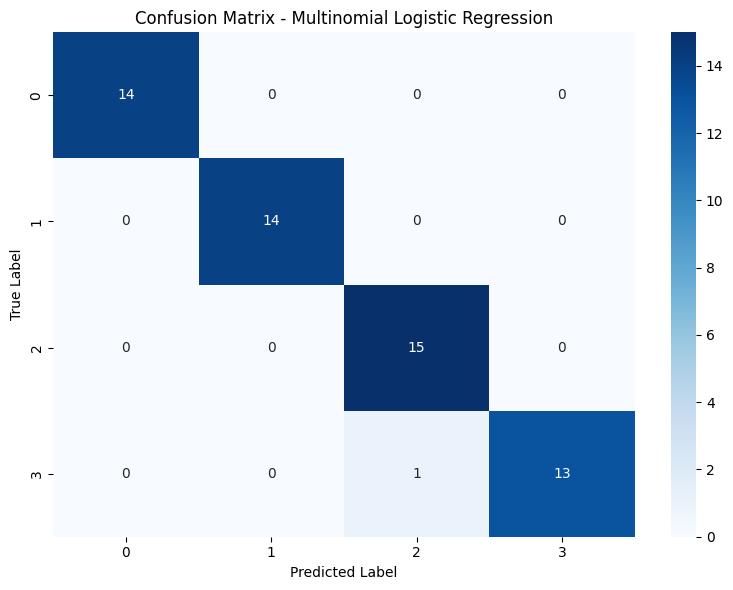

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Features including cluster ---
features_with_cluster = features + ['Cluster']
X = df_cluster[features_with_cluster]
y = df_cluster['Recommend_MM']

# --- Check original class distribution ---
print("Original class distribution:\n", y.value_counts())

# --- Scale features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Apply SMOTE ---
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# --- Check class distribution after SMOTE ---
print("\nResampled class distribution:\n", Counter(y_resampled))

# --- Split into train and test sets ---
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# --- Train multinomial logistic regression ---
model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
model.fit(X_train, y_train)

# --- Predict and evaluate ---
y_pred = model.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Confusion matrix ---
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Multinomial Logistic Regression')
plt.tight_layout()
plt.show()






Original class distribution:
 Recommend_MM
3    71
2    20
1     7
0     6
Name: count, dtype: int64

Resampled class distribution:
 Counter({3: 71, 2: 71, 0: 71, 1: 71})

Accuracy: 0.9122807017543859

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.87      0.93      0.90        14
           2       1.00      0.93      0.97        15
           3       0.86      0.86      0.86        14

    accuracy                           0.91        57
   macro avg       0.91      0.91      0.91        57
weighted avg       0.91      0.91      0.91        57



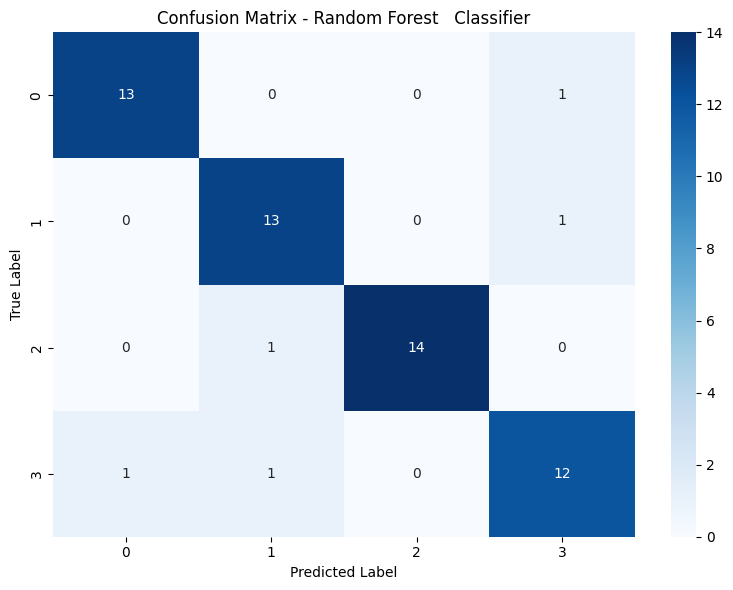

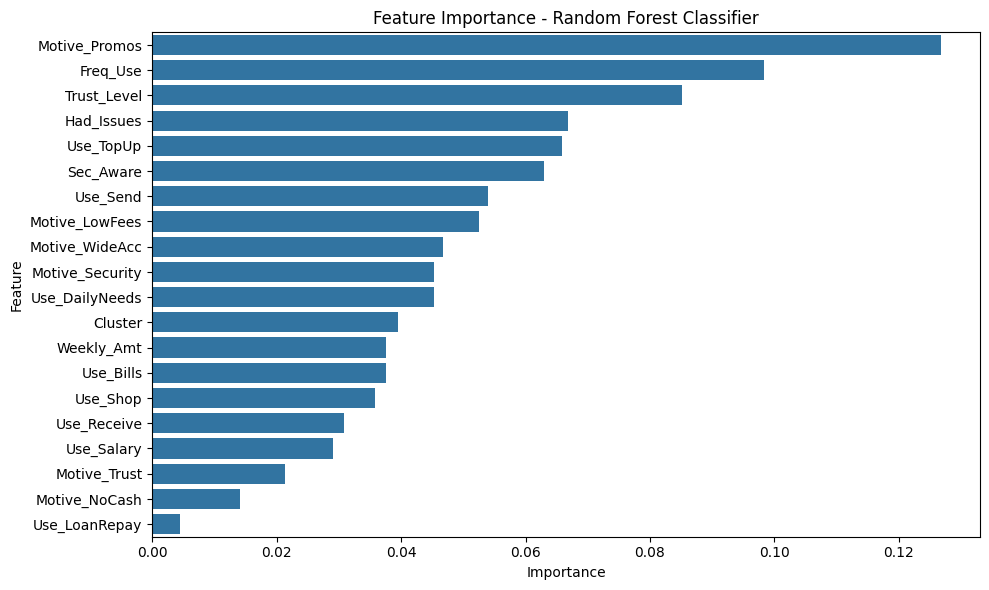

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Define Features ---
features = [
    'Freq_Use', 'Weekly_Amt', 'Trust_Level', 'Had_Issues', 'Sec_Aware',
    'Use_Send', 'Use_Receive', 'Use_TopUp', 'Use_LoanRepay', 'Use_DailyNeeds',
    'Use_Bills', 'Use_Shop', 'Use_Salary', 'Motive_LowFees', 'Motive_Security',
    'Motive_Trust', 'Motive_Promos', 'Motive_WideAcc', 'Motive_NoCash'
]

# --- Include 'Cluster' if available ---
features_with_cluster = features + ['Cluster']
X = df_cluster[features_with_cluster]
y = df_cluster['Recommend_MM']

# --- Check original class distribution ---
print("Original class distribution:\n", y.value_counts())

# --- Scale features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Apply SMOTE to handle class imbalance ---
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# --- Check resampled class distribution ---
print("\nResampled class distribution:\n", Counter(y_resampled))

# --- Split data into training and testing sets ---
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# --- Initialize and train Random Forest Classifier ---
rf_model = RandomForestClassifier(
    n_estimators=100,         # Number of trees
    max_depth=None,           # Maximum depth of each tree
    random_state=42,          # For reproducibility
    class_weight='balanced'   # Adjust weights to handle class imbalance
)
rf_model.fit(X_train, y_train)

# --- Make predictions ---
y_pred = rf_model.predict(X_test)

# --- Evaluate model performance ---
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Random Forest   Classifier')
plt.tight_layout()
plt.show()

# --- Feature Importance ---
feature_importances = pd.DataFrame({
    'Feature': features_with_cluster,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance - Random Forest Classifier')
plt.tight_layout()
plt.show()


In [25]:
!pip install flask-ngrok imbalanced-learn


In [26]:
!pip install pyngrok

In [27]:
!pip install flask flask-ngrok imbalanced-learn pyngrok

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

from flask import Flask, render_template_string, request, jsonify
import io
import base64
import matplotlib
matplotlib.use('Agg')  # Use Agg backend for non-interactive plotting

# Ngrok imports and setup
from pyngrok import ngrok
import threading
import time
import sys
import qrcode # Import qrcode library

print("🏦 Enhanced Mobile Money Usage Predictor with ML Clustering")
print("=" * 60)

# --- NGROK SETUP ---
try:
    ngrok.set_auth_token("2ykfE7uVzBEOFxqR0SyRQHKtAMa_6fcEZCzxASepEJ1HdWJfg")
    print("✅ ngrok authtoken set.")
except Exception as e:
    print(f"❌ Error setting ngrok authtoken: {e}")
    sys.exit(1)

# Define the port for Flask
FLASK_PORT = 5003

# --- DATA PREPARATION AND MODEL TRAINING ---

# Load your Excel file
try:
    df = pd.read_excel("Mobile_Money.xlsx")
    print(f"✅ Dataset loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print("❌ Please ensure 'Mobile_Money.xlsx' is in the same directory")
    sys.exit(1)

# Define mapping dictionaries
freq_map = {'Rarely': 0, 'A few times a month': 1, 'Once a week': 2, 'A few times a week': 3, 'Daily': 4}
amt_map = {'Below 25': 1, '25 - 100': 2, '100–300': 3, 'Over 300': 4}
trust_map = {'Neutral': 1, 'Somewhat trust': 2, 'Strongly trust': 3}
recommend_map = {'No': 0, 'Not sure': 1, 'Maybe': 2, 'Yes': 3}
issues_map = {'No': 0, 'Yes': 1}
sec_aware_map = {'No': 0, 'Somewhat trust': 1, 'Yes': 2}

# User-friendly mappings
prediction_letters = {0: 'D', 1: 'C', 2: 'B', 3: 'A'}
letter_meanings = {
    'A': 'High Recommendation (Strongly Recommended)',
    'B': 'Moderate Recommendation (Possibly Recommended)',
    'C': 'Uncertain (Undecided)',
    'D': 'Low Recommendation (Not Recommended)'
}

# Create a copy of the dataframe for processing
df_processed = df.copy()

# Apply numerical mappings
df_processed['Freq_Use'] = df_processed['Freq_Use'].map(freq_map)
df_processed['Weekly_Amt'] = df_processed['Weekly_Amt'].map(amt_map)
df_processed['Trust_Level'] = df_processed['Trust_Level'].map(trust_map)
df_processed['Recommend_MM'] = df_processed['Recommend_MM'].map(recommend_map)
df_processed['Had_Issues'] = df_processed['Had_Issues'].map(issues_map)
df_processed['Sec_Aware'] = df_processed['Sec_Aware'].map(sec_aware_map)

# Fill missing values
df_processed = df_processed.fillna(0)

# Define features for clustering
features_for_clustering = [
    'Freq_Use', 'Weekly_Amt', 'Trust_Level', 'Had_Issues', 'Sec_Aware',
    'Use_Send', 'Use_Receive', 'Use_TopUp', 'Use_LoanRepay', 'Use_DailyNeeds',
    'Use_Bills', 'Use_Shop', 'Use_Salary', 'Motive_LowFees', 'Motive_Security',
    'Motive_Trust', 'Motive_Promos', 'Motive_WideAcc', 'Motive_NoCash'
]

# --- CLUSTERING STEP ---
print("\n🤖 Performing K-Means Clustering...")

X_clustering = df_processed[features_for_clustering]
scaler_clustering = StandardScaler()
X_clustering_scaled = scaler_clustering.fit_transform(X_clustering)

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df_processed['Cluster'] = kmeans.fit_predict(X_clustering_scaled)

def analyze_clusters(df_with_clusters):
    cluster_descriptions = {}
    for cluster_id in sorted(df_with_clusters['Cluster'].unique()):
        cluster_data = df_with_clusters[df_with_clusters['Cluster'] == cluster_id]

        # Calculate means
        avg_freq = cluster_data['Freq_Use'].mean()
        avg_amt = cluster_data['Weekly_Amt'].mean()
        avg_trust = cluster_data['Trust_Level'].mean()
        avg_issues = cluster_data['Had_Issues'].mean()
        avg_sec_aware = cluster_data['Sec_Aware'].mean()
        avg_recommend = cluster_data['Recommend_MM'].mean()
        avg_use_send = cluster_data['Use_Send'].mean()
        avg_motive_security = cluster_data['Motive_Security'].mean()

        # Custom logic to describe clusters
        if avg_freq >= 3.5 and avg_amt >= 3.5 and avg_trust >= 2.5 and avg_use_send >= 0.7:
            desc = "🚀 **Power Users** - Very high usage, high spending, strong trust, frequently send money."
        elif avg_trust >= 2.5 and avg_sec_aware >= 1.5 and avg_issues < 0.2 and avg_motive_security >= 0.7:
            desc = "🛡️ **Trusted & Secure Users** - High trust, security-conscious, few issues, prioritize security."
        elif avg_freq <= 1.0 and avg_issues >= 0.5:
            desc = "⚠️ **Cautious & Problematic Users** - Low usage, and have experienced significant issues."
        elif avg_recommend >= 2.5:
            desc = "🌟 **Enthusiastic Recommenders** - Tend to highly recommend mobile money to others."
        else:
            desc = "⚖️ **Moderate Users** - Balanced usage profile with average characteristics."
        cluster_descriptions[cluster_id] = desc
    return cluster_descriptions

cluster_descriptions = analyze_clusters(df_processed)

# --- MODEL TRAINING ---
print("\n🎯 Training Machine Learning Model...")

features_for_prediction_model = features_for_clustering + ['Cluster']
X_model = df_processed[features_for_prediction_model]
y_model = df_processed['Recommend_MM']

scaler = StandardScaler()
X_scaled_model = scaler.fit_transform(X_model)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled_model, y_model)

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)
rf_model.fit(X_train, y_train)

# --- Evaluate model performance ---
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

feature_importance_df = pd.DataFrame({
    'Feature': features_for_prediction_model,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

def generate_feature_importance_plot(feature_importances_df):
    plt.figure(figsize=(10, 7))
    sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(10), palette='viridis')
    plt.title('Top 10 Feature Importances', fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8')
    plt.close()
    return image_base64

# --- FLASK APPLICATION ---

app = Flask(__name__)

flask_field_to_feature_map = {
    'freq_use': 'Freq_Use', 'weekly_amt': 'Weekly_Amt', 'trust_level': 'Trust_Level',
    'had_issues': 'Had_Issues', 'sec_aware': 'Sec_Aware', 'use_send': 'Use_Send',
    'use_receive': 'Use_Receive', 'use_topup': 'Use_TopUp', 'use_loanrepay': 'Use_LoanRepay',
    'use_dailyneeds': 'Use_DailyNeeds', 'use_bills': 'Use_Bills', 'use_shop': 'Use_Shop',
    'use_salary': 'Use_Salary', 'motive_lowfees': 'Motive_LowFees', 'motive_security': 'Motive_Security',
    'motive_trust': 'Motive_Trust', 'motive_promos': 'Motive_Promos', 'motive_wideacc': 'Motive_WideAcc',
    'motive_nocash': 'Motive_NoCash'
}

friendly_feature_names = {
    'Freq_Use': 'Usage Frequency',
    'Weekly_Amt': 'Weekly Spending',
    'Trust_Level': 'Trust in MM Service',
    'Had_Issues': 'Experienced Issues',
    'Sec_Aware': 'Security Awareness',
    'Use_Send': 'Send Money',
    'Use_Receive': 'Receive Money',
    'Use_TopUp': 'Top Up Airtime',
    'Use_LoanRepay': 'Loan Repayment',
    'Use_DailyNeeds': 'Daily Needs Purchases',
    'Use_Bills': 'Pay Bills',
    'Use_Shop': 'Shopping',
    'Use_Salary': 'Receive Salary',
    'Motive_LowFees': 'Low Fees',
    'Motive_Security': 'Security',
    'Motive_Trust': 'Trust',
    'Motive_Promos': 'Promotions',
    'Motive_WideAcc': 'Wide Acceptance',
    'Motive_NoCash': 'Cashless Convenience',
    'Cluster': 'AI User Segment'
}

feature_impact_explanations = {
    'Freq_Use': {
        0: "Rare usage often correlates with lower engagement and recommendation.",
        1: "Limited usage per month, suggesting moderate engagement.",
        2: "Consistent weekly usage generally indicates growing reliance.",
        3: "Frequent weekly usage is a strong indicator of high dependence.",
        4: "Daily usage is a very strong positive sign for recommendation, indicating deep integration into daily life."
    },
    'Weekly_Amt': {
        1: "Low spending might mean limited use cases or low trust.",
        2: "Moderate spending indicates a useful, but not primary, financial tool.",
        3: "Significant spending suggests mobile money is a key financial tool.",
        4: "Very high spending strongly correlates with deep reliance and positive recommendation."
    },
    'Trust_Level': {
        1: "Neutral trust can limit recommendation.",
        2: "Somewhat trusting users are more likely to recommend than neutral ones.",
        3: "Strong trust is a critical factor for high recommendation, indicating user confidence."
    },
    'Had_Issues': {
        0: "No issues experienced is a positive sign for recommendation, showing reliability.",
        1: "Having experienced issues can significantly lower a user's likelihood to recommend due to frustration."
    },
    'Sec_Aware': {
        0: "Low security awareness might mean the user is less concerned, but also potentially less confident in the service.",
        1: "Somewhat security aware users are more engaged with security, which can lead to higher trust if concerns are met.",
        2: "High security awareness often means the user values robust security measures, and if satisfied, can lead to strong recommendation."
    },
    'Use_Send': "Using 'Send Money' is a core mobile money function, often indicating active engagement.",
    'Use_Receive': "Using 'Receive Money' highlights the utility of mobile money for incoming funds.",
    'Use_TopUp': "Using 'Top Up Airtime' is a common, convenient feature, suggesting practical daily use.",
    'Use_LoanRepay': "Using 'Loan Repayment' indicates deeper financial integration and reliance.",
    'Use_DailyNeeds': "Using for 'Daily Needs' shows the service is used for routine transactions, implying high utility.",
    'Use_Bills': "Using 'Pay Bills' demonstrates significant convenience and integration into a user's financial life.",
    'Use_Shop': "Using for 'Shopping' implies acceptance and ease of use in retail, a positive for recommendation.",
    'Use_Salary': "Receiving 'Salary' via mobile money is a very strong indicator of deep trust and reliance.",
    'Motive_LowFees': "Prioritizing 'Low Fees' suggests value-consciousness; satisfying this motive is key for recommendation.",
    'Motive_Security': "Prioritizing 'Security' is a strong indicator that if security needs are met, recommendation will be high.",
    'Motive_Trust': "Prioritizing 'Trust' highlights the importance of reliability and integrity for the user.",
    'Motive_Promos': "Driven by 'Promotions' suggests price sensitivity; good offers can boost recommendation.",
    'Motive_WideAcc': "Prioritizing 'Wide Acceptance' indicates the user values the convenience of widespread usability.",
    'Motive_NoCash': "Driven by 'Cashless Convenience' shows the user values ease and modernity, a good sign for adoption.",
    'Cluster': "Your 'AI User Segment' (cluster) groups you with similar users, and their general recommendation patterns influence your prediction."
}

def generate_user_centric_feature_impact_summary(user_input_data_dict, model, features_list, friendly_names_map, feature_explanations, top_n=7):
    impact_summary = []
    importance_df = pd.DataFrame({
        'feature': features_list,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    top_global_features = importance_df['feature'].head(top_n).tolist()

    for feature_name_original in top_global_features:
        friendly_name = friendly_names_map.get(feature_name_original, feature_name_original)
        user_value = user_input_data_dict.get(feature_name_original)
        explanation = "Information not available."

        if feature_name_original == 'Cluster':
            if user_value is not None:
                explanation = f"Your profile falls into Segment {user_value}. This segment typically has characteristics that lead to a certain recommendation."
                explanation += " " + cluster_descriptions.get(user_value, "")
        elif feature_name_original in feature_explanations:
            feature_exp_data = feature_explanations[feature_name_original]
            if isinstance(feature_exp_data, dict):
                if user_value is not None and user_value in feature_exp_data:
                    explanation = feature_exp_data[user_value]
                else:
                    explanation = f"Your selection for '{friendly_name}' ({user_value}) is relevant."
            else:
                if user_value == 1:
                    explanation = f"Your selection for '{friendly_name}' is significant: {feature_exp_data}"
                elif user_value == 0 and 'Had_Issues' in feature_name_original:
                    explanation = feature_explanations['Had_Issues'][0]
                else:
                    continue

        if user_value is not None:
            display_user_value = user_value
            if feature_name_original == 'Freq_Use':
                display_user_value = {0:'Rarely', 1:'A few times a month', 2:'Once a week', 3:'A few times a week', 4:'Daily'}.get(user_value, user_value)
            elif feature_name_original == 'Weekly_Amt':
                display_user_value = {1:'Below $25', 2:'$25 - $100', 3:'$100 - $300', 4:'Over $300'}.get(user_value, user_value)
            elif feature_name_original == 'Trust_Level':
                display_user_value = {1:'Neutral', 2:'Somewhat trust', 3:'Strongly trust'}.get(user_value, user_value)
            elif feature_name_original == 'Had_Issues':
                display_user_value = {0:'No issues', 1:'Yes, had issues'}.get(user_value, user_value)
            elif feature_name_original == 'Sec_Aware':
                display_user_value = {0:'Not security aware', 1:'Somewhat aware', 2:'Very security aware'}.get(user_value, user_value)
            elif feature_name_original.startswith('Use_') or feature_name_original.startswith('Motive_'):
                display_user_value = "Selected" if user_value == 1 else "Not Selected"

            if feature_name_original != 'Cluster' and user_value != 0:
                impact_summary.append({
                    'feature_name': friendly_name,
                    'user_input': display_user_value,
                    'explanation': explanation
                })
            elif feature_name_original == 'Cluster':
                    impact_summary.append({
                        'feature_name': friendly_name,
                        'user_input': display_user_value,
                        'explanation': explanation
                    })
            elif feature_name_original == 'Had_Issues' and user_value == 0:
                impact_summary.append({
                    'feature_name': friendly_name,
                    'user_input': display_user_value,
                    'explanation': explanation
                })

    return impact_summary

def generate_suggestions(user_data, prediction_letter, user_impact_summary):
    suggestions = []
    if prediction_letter == 'A':
        suggestions.append("🎉 **Excellent!** Your profile suggests you're a strong advocate for mobile money. Keep enjoying the benefits!")
    elif prediction_letter == 'B':
        suggestions.append("👍 **Good potential!** You're likely to recommend mobile money. Minor adjustments could strengthen your experience.")
    elif prediction_letter == 'C':
        suggestions.append(" 🔍   **Opportunity for Growth!** Your recommendation is uncertain. Let's look at ways to improve your experience.")
    else:
        suggestions.append("🤔 **Areas for Improvement!** Your profile suggests low likelihood of recommendation. Let's identify pain points.")

    for item in user_impact_summary:
        feature = item['feature_name']
        user_value = item['user_input']

        if feature == 'Usage Frequency':
            if user_value == 'Rarely' or user_value == 'A few times a month':
                suggestions.append("👉 **Increase Usage:** Try using mobile money for more routine transactions like daily purchases or bill payments to see its full convenience.")
        elif feature == 'Weekly Spending':
            if user_value == 'Below $25' or user_value == '$25 - $100':
                suggestions.append("💰 **Explore More Transactions:** Consider using mobile money for larger transactions or for receiving salary if applicable, to maximize its utility.")
        elif feature == 'Trust in MM Service':
            if user_value == 'Neutral' or user_value == 'Somewhat trust':
                suggestions.append("🤝 **Build Trust:** Research the service's security features, customer support, and read reviews. Reporting issues promptly can also help resolve concerns.")
        elif feature == 'Experienced Issues':
            if user_value == 'Yes, had issues':
                suggestions.append("🛠️ **Resolve Issues:** If you've had issues, reach out to customer support to get them resolved. A smooth issue resolution process can significantly improve your view of the service.")
        elif feature == 'Security Awareness': # Changed from 'Security Awareness Level' to match friendly_feature_names
            if user_value == 'Not security aware' or user_value == 'Somewhat aware':
                suggestions.append("🔒 **Enhance Security Practices:** Learn about protecting your mobile money account (e.g., strong PINs, avoiding phishing). This can boost your confidence and usage.")
        elif feature == 'Security' and user_data.get('Motive_Security') == 0: # Changed from 'Motivation: Security' to match friendly_feature_names
            suggestions.append("🚨 **Prioritize Security:** Understanding and appreciating the security measures of mobile money can lead to greater trust and a better overall experience.")
        elif feature == 'Trust' and user_data.get('Motive_Trust') == 0: # Changed from 'Motivation: Trust' to match friendly_feature_names
            suggestions.append("❤️ **Focus on Reliability:** Reliability is key. Look for a service provider with a strong track record and transparent policies to build trust.")
        elif feature == 'Send Money' and user_data.get('Use_Send') == 0: # Changed from 'Uses "Send Money"' to match friendly_feature_names
            suggestions.append("➡️ **Utilize Core Features:** 'Sending Money' is a fundamental and highly convenient feature. Try it for family transfers or splitting bills.")
        elif feature == 'Receive Money' and user_data.get('Use_Receive') == 0: # Changed from 'Uses "Receive Money"' to match friendly_feature_names
            suggestions.append("⬅️ **Receive Payments:** If possible, consider receiving payments or contributions via mobile money to streamline your finances.")
        elif feature == 'Pay Bills' and user_data.get('Use_Bills') == 0: # Changed from 'Uses "Pay Bills"' to match friendly_feature_names
            suggestions.append(" 🔍   **Simplify Bill Payments:** Paying bills through mobile money can save time and effort. Explore this feature for utilities, internet, etc.")
        elif feature == 'Shopping' and user_data.get('Use_Shop') == 0: # Changed from 'Uses "Shopping"' to match friendly_feature_names
            suggestions.append("🛍️ **Convenient Shopping:** Use mobile money for shopping in stores or online where accepted. It's often quicker and safer than cash.")
        elif feature == 'Receive Salary' and user_data.get('Use_Salary') == 0: # Changed from 'Uses "Receive Salary"' to match friendly_feature_names
            suggestions.append("💼 **Direct Salary Deposit:** If your employer offers it, receiving your salary directly into your mobile money account can enhance financial management.")
        elif feature == 'AI User Segment':
            if "Cautious & Problematic Users" in cluster_descriptions.get(user_data.get('Cluster'), ''):
                suggestions.append("🩹 **Address Specific Problems:** As a cautious user who has faced issues, focusing on resolving those specific problems with customer support is crucial for a better experience.")
            elif "Moderate Users" in cluster_descriptions.get(user_data.get('Cluster'), ''):
                suggestions.append("📈 **Unlock More Value:** As a moderate user, explore advanced features or new ways to integrate mobile money into your daily routine to get more value.")

    return list(dict.fromkeys(suggestions))

# Function to generate QR code
def generate_qr_code(data):
    qr = qrcode.QRCode(
        version=1,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=10,
        border=4,
    )
    qr.add_data(data)
    qr.make(fit=True)
    img = qr.make_image(fill_color="black", back_color="white")

    buf = io.BytesIO()
    img.save(buf, format='PNG')
    buf.seek(0)
    image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8')
    return image_base64

# --- FLASK ROUTES ---

HTML_TEMPLATE = '''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>💰 Mobile Money Predictor</title>
    <link href="https://fonts.googleapis.com/css2?family=Poppins:wght@300;400;500;600;700;800;900&display=swap" rel="stylesheet">
    <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/6.4.0/css/all.min.css">
    <style>
        :root {
            --primary: #6a11cb;
            --primary-light: #8a3ffc;
            --secondary: #2575fc;
            --accent: #00d4ff;
            --success: #00c853;
            --info: #2962ff;
            --warning: #ffab00;
            --danger: #ff1744;
            --dark: #1a1a2e;
            --light: #f8f9fa;
            --glass: rgba(255, 255, 255, 0.1);
            --glass-border: rgba(255, 255, 255, 0.2);
            --glass-shadow: 0 8px 32px 0 rgba(31, 38, 135, 0.15);
            --card-shadow: 0 10px 40px rgba(0, 0, 0, 0.15);
            --border-radius: 24px;
            --transition: all 0.4s cubic-bezier(0.25, 0.8, 0.25, 1);
        }

        * {
            margin: 0;
            padding: 0;
            box-sizing: border-box;
        }

        body {
            font-family: 'Poppins', sans-serif;
            background: linear-gradient(135deg, #1a1a2e 0%, #16213e 100%);
            color: white;
            line-height: 1.6;
            min-height: 100vh;
            padding: 2rem;
            overflow-x: hidden;
            position: relative;
        }

        body::before {
            content: '';
            position: absolute;
            top: 0;
            left: 0;
            width: 100%;
            height: 100%;
            background:
                radial-gradient(circle at 10% 20%, rgba(106, 17, 203, 0.2) 0%, transparent 40%),
                radial-gradient(circle at 90% 80%, rgba(37, 117, 252, 0.2) 0%, transparent 40%);
            z-index: -1;
        }

        .bubble-bg {
            position: fixed;
            top: 0;
            left: 0;
            width: 100%;
            height: 100%;
            pointer-events: none;
            z-index: -1;
            overflow: hidden;
        }

        .bubble {
            position: absolute;
            border-radius: 50%;
            background: rgba(255, 255, 255, 0.05);
            box-shadow:
                0 0 20px rgba(106, 17, 203, 0.2),
                inset 0 0 10px rgba(255, 255, 255, 0.1);
            animation: float 15s infinite linear;
            opacity: 0.7;
        }

        @keyframes float {
            0% {
                transform: translateY(100vh) scale(0.5);
                opacity: 0;
            }
            10% {
                opacity: 0.7;
            }
            90% {
                opacity: 0.7;
            }
            100% {
                transform: translateY(-20vh) scale(1.2);
                opacity: 0;
            }
        }

        .container {
            max-width: 1800px;
            margin: 0 auto;
            display: grid;
            grid-template-columns: 1fr 1.2fr;
            gap: 2.5rem;
            z-index: 1;
        }

        .card {
            background: var(--glass);
            backdrop-filter: blur(16px);
            -webkit-backdrop-filter: blur(16px);
            border-radius: var(--border-radius);
            padding: 2.5rem;
            transition: var(--transition);
            border: 1px solid var(--glass-border);
            box-shadow: var(--glass-shadow);
            position: relative;
            overflow: hidden;
            z-index: 2;
        }

        .card::after {
            content: '';
            position: absolute;
            top: -50%;
            left: -50%;
            width: 200%;
            height: 200%;
            background: linear-gradient(45deg, transparent, rgba(255, 255, 255, 0.05), transparent);
            transform: rotate(30deg);
            z-index: -1;
        }

        .card:hover {
            transform: translateY(-10px);
            box-shadow: 0 20px 50px rgba(106, 17, 203, 0.3);
            border-color: rgba(106, 17, 203, 0.4);
        }

        .header {
            grid-column: 1 / -1;
            text-align: center;
            padding: 3rem;
            background: linear-gradient(135deg, var(--primary) 0%, var(--secondary) 100%);
            border-radius: var(--border-radius);
            margin-bottom: 2.5rem;
            position: relative;
            overflow: hidden;
            box-shadow: 0 10px 30px rgba(106, 17, 203, 0.3);
            border: 1px solid rgba(255, 255, 255, 0.2);
            z-index: 2;
        }

        .header::before {
            content: '';
            position: absolute;
            top: 0;
            left: 0;
            width: 100%;
            height: 100%;
            background:
                radial-gradient(circle at 20% 30%, rgba(255, 255, 255, 0.1) 0%, transparent 40%),
                radial-gradient(circle at 80% 70%, rgba(255, 255, 255, 0.1) 0%, transparent 40%);
        }

        .header h1 {
            font-size: 3.5rem;
            font-weight: 800;
            margin-bottom: 1rem;
            letter-spacing: -0.5px;
            text-shadow: 0 2px 10px rgba(0, 0, 0, 0.2);
            position: relative;
            background: linear-gradient(to right, #00d4ff, #ffffff);
            -webkit-background-clip: text;
            background-clip: text;
            color: transparent;
        }

        .header p {
            font-size: 1.4rem;
            opacity: 0.9;
            max-width: 800px;
            margin: 0 auto;
            position: relative;
        }

        .section-title {
            display: flex;
            align-items: center;
            gap: 1.2rem;
            margin-bottom: 2rem;
            font-size: 1.8rem;
            color: white;
            padding-bottom: 1rem;
            border-bottom: 1px solid rgba(255, 255, 255, 0.1);
            position: relative;
        }

        .section-title i {
            font-size: 2rem;
            background: linear-gradient(135deg, var(--accent), var(--secondary));
            -webkit-background-clip: text;
            background-clip: text;
            color: transparent;
        }

        .form-group {
            margin-bottom: 1.8rem;
            position: relative;
        }

        .form-group label {
            display: block;
            margin-bottom: 0.8rem;
            font-weight: 600;
            font-size: 1.1rem;
            display: flex;
            align-items: center;
            gap: 0.8rem;
            color: #e0e0ff;
        }

        .form-group label i {
            width: 36px;
            height: 36px;
            background: rgba(106, 17, 203, 0.2);
            border-radius: 50%;
            display: flex;
            align-items: center;
            justify-content: center;
            color: var(--accent);
        }

        .form-control {
            width: 100%;
            padding: 1.1rem 1.5rem;
            border: 2px solid rgba(255, 255, 255, 0.1);
            border-radius: 16px;
            font-size: 1.1rem;
            transition: var(--transition);
            background: rgba(0, 0, 0, 0.2);
            color: white;
            font-weight: 500;
        }

        .form-control:focus {
            border-color: var(--primary-light);
            outline: none;
            box-shadow: 0 0 0 4px rgba(106, 17, 203, 0.15);
            background: rgba(0, 0, 0, 0.3);
        }

        .checkbox-grid {
            display: grid;
            grid-template-columns: repeat(auto-fill, minmax(200px, 1fr));
            gap: 1.2rem;
        }

        .checkbox-item {
            display: flex;
            align-items: center;
            gap: 1rem;
            padding: 1.2rem;
            background: rgba(0, 0, 0, 0.2);
            border-radius: 16px;
            cursor: pointer;
            transition: var(--transition);
            border: 2px solid rgba(255, 255, 255, 0.05);
            position: relative;
            overflow: hidden;
            backdrop-filter: blur(10px);
        }

        .checkbox-item::before {
            content: '';
            position: absolute;
            top: 0;
            left: 0;
            width: 5px;
            height: 100%;
            background: var(--primary);
            opacity: 0;
            transition: var(--transition);
        }

        .checkbox-item:hover {
            background: rgba(106, 17, 203, 0.1);
            border-color: rgba(106, 17, 203, 0.3);
            transform: translateY(-5px);
        }

        .checkbox-item:hover::before {
            opacity: 1;
        }

        .checkbox-item input {
            width: 22px;
            height: 22px;
            cursor: pointer;
            accent-color: var(--primary);
            flex-shrink: 0;
        }

        .checkbox-item span {
            font-weight: 500;
            color: #e0e0ff;
        }

        .checkbox-item i {
            color: var(--accent);
            font-size: 1.2rem;
        }

        .btn-submit {
            background: linear-gradient(135deg, var(--primary) 0%, var(--secondary) 100%);
            color: white;
            border: none;
            padding: 1.4rem 2.5rem;
            font-size: 1.2rem;
            font-weight: 700;
            border-radius: 16px;
            cursor: pointer;
            width: 100%;
            transition: var(--transition);
            display: flex;
            justify-content: center;
            align-items: center;
            gap: 1.2rem;
            margin-top: 1.5rem;
            box-shadow: 0 8px 20px rgba(106, 17, 203, 0.4);
            position: relative;
            overflow: hidden;
            z-index: 1;
            backdrop-filter: blur(10px);
            border: 1px solid rgba(255, 255, 255, 0.1);
        }

        .btn-submit::before {
            content: '';
            position: absolute;
            top: 0;
            left: 0;
            width: 100%;
            height: 100%;
            background: linear-gradient(135deg, var(--primary-light) 0%, var(--accent) 100%);
            opacity: 0;
            transition: var(--transition);
            z-index: -1;
        }

        .btn-submit:hover {
            transform: translateY(-5px);
            box-shadow: 0 15px 30px rgba(106, 17, 203, 0.5);
        }

        .btn-submit:hover::before {
            opacity: 1;
        }

        /* Prediction Results */
        .prediction-container {
            position: relative;
            padding: 3rem;
            border-radius: var(--border-radius);
            margin-bottom: 2.5rem;
            background: rgba(0, 0, 0, 0.2);
            box-shadow: var(--glass-shadow);
            text-align: center;
            border: 1px solid var(--glass-border);
            overflow: hidden;
            backdrop-filter: blur(16px);
        }

        .prediction-container::before {
            content: '';
            position: absolute;
            top: 0;
            left: 0;
            width: 100%;
            height: 100%;
            background:
                radial-gradient(circle at 10% 20%, rgba(255, 255, 255, 0.05) 0%, transparent 40%),
                radial-gradient(circle at 90% 80%, rgba(255, 255, 255, 0.05) 0%, transparent 40%);
            z-index: -1;
        }

        .prediction-box {
            display: flex;
            flex-direction: column;
            align-items: center;
            justify-content: center;
            gap: 1.5rem;
            margin-bottom: 2rem;
        }

        .prediction-letter {
            font-size: 5rem;
            font-weight: 900;
            background: linear-gradient(135deg, var(--accent) 0%, #ffffff 100%);
            -webkit-background-clip: text;
            background-clip: text;
            color: transparent;
            line-height: 1;
            text-shadow: 0 5px 20px rgba(0, 0, 0, 0.3);
            display: inline-block;
            padding: 0.5rem 1.5rem;
            border-radius: 12px;
            border: 2px solid rgba(255, 255, 255, 0.2);
            backdrop-filter: blur(10px);
        }

        .prediction-text {
            font-size: 1.8rem;
            font-weight: 600;
            color: #e0e0ff;
            max-width: 600px;
            margin: 0 auto;
        }

        .sub-heading {
            font-size: 1.5rem;
            font-weight: 600;
            color: var(--accent);
            margin-top: 2.5rem;
            margin-bottom: 1.5rem;
            text-align: left;
            border-bottom: 1px dashed rgba(255, 255, 255, 0.1);
            padding-bottom: 0.8rem;
        }

        .feature-impact-list, .suggestions-list {
            list-style: none;
            padding: 0;
            margin: 0;
            text-align: left;
        }

        .feature-impact-list li, .suggestions-list li {
            background: rgba(0, 0, 0, 0.2);
            padding: 1.2rem 1.8rem;
            border-radius: 12px;
            margin-bottom: 1rem;
            border: 1px solid rgba(255, 255, 255, 0.1);
            display: flex;
            flex-direction: column;
            gap: 0.5rem;
            font-size: 1rem;
        }

        .feature-impact-list li strong, .suggestions-list li strong {
            color: var(--primary-light);
            font-size: 1.1rem;
        }

        .feature-impact-list li span {
            color: #ccc;
            font-style: italic;
        }

        .suggestions-list li {
            background: rgba(37, 117, 252, 0.1);
            border-color: rgba(37, 117, 252, 0.3);
            position: relative;
            padding-left: 2.5rem;
        }

        .suggestions-list li::before {
            content: '  ';
            position: absolute;
            left: 1rem;
            top: 50%;
            transform: translateY(-50%);
            font-size: 1.2rem;
        }

        .chart-container {
            width: 100%;
            height: auto;
            max-width: 600px; /* Adjust as needed */
            margin: 2rem auto;
            background: rgba(0, 0, 0, 0.2);
            border-radius: 16px;
            padding: 1.5rem;
            border: 1px solid rgba(255, 255, 255, 0.1);
            box-shadow: 0 5px 15px rgba(0, 0, 0, 0.2);
        }

        .chart-container img {
            max-width: 100%;
            height: auto;
            display: block;
            border-radius: 10px;
        }

        .accuracy-info {
            background: rgba(0, 0, 0, 0.2);
            padding: 1rem 1.5rem;
            border-radius: 12px;
            margin-top: 2rem;
            font-size: 1rem;
            border: 1px solid rgba(255, 255, 255, 0.1);
            text-align: center;
        }

        .accuracy-info strong {
            color: var(--accent);
        }

        /* QR Code Container */
        .qr-code-container {
            margin-top: 2rem;
            text-align: center;
        }

        .qr-code-container h3 {
            color: var(--accent);
            margin-bottom: 1rem;
        }

        .qr-code-container img {
            width: 150px;
            height: 150px;
            border: 5px solid white;
            border-radius: 8px;
            background: white;
        }

        /* Responsive Design */
        @media (max-width: 1200px) {
            .container {
                grid-template-columns: 1fr;
            }
            .header {
                padding: 2rem;
                margin-bottom: 1.5rem;
            }
            .header h1 {
                font-size: 2.8rem;
            }
            .header p {
                font-size: 1.2rem;
            }
            .card {
                padding: 2rem;
            }
            .section-title {
                font-size: 1.5rem;
                margin-bottom: 1.5rem;
            }
            .form-group label {
                font-size: 1rem;
            }
            .form-control {
                padding: 0.9rem 1.2rem;
                font-size: 1rem;
            }
            .checkbox-grid {
                grid-template-columns: repeat(auto-fill, minmax(150px, 1fr));
                gap: 1rem;
            }
            .checkbox-item {
                padding: 1rem;
            }
            .checkbox-item input {
                width: 20px;
                height: 20px;
            }
            .checkbox-item span {
                font-size: 0.9rem;
            }
            .btn-submit {
                padding: 1.2rem 2rem;
                font-size: 1.1rem;
            }
            .prediction-container {
                padding: 2rem;
            }
            .prediction-letter {
                font-size: 4rem;
            }
            .prediction-text {
                font-size: 1.5rem;
            }
            .sub-heading {
                font-size: 1.3rem;
                margin-top: 2rem;
                margin-bottom: 1rem;
            }
            .feature-impact-list li, .suggestions-list li {
                padding: 1rem 1.5rem;
                font-size: 0.9rem;
            }
            .feature-impact-list li strong, .suggestions-list li strong {
                font-size: 1rem;
            }
        }

        @media (max-width: 768px) {
            body {
                padding: 1rem;
            }
            .header {
                padding: 1.5rem;
                margin-bottom: 1rem;
            }
            .header h1 {
                font-size: 2.2rem;
            }
            .header p {
                font-size: 1rem;
            }
            .card {
                padding: 1.5rem;
            }
            .section-title {
                font-size: 1.3rem;
                margin-bottom: 1rem;
                flex-direction: column;
                align-items: flex-start;
                gap: 0.5rem;
            }
            .section-title i {
                font-size: 1.5rem;
            }
            .form-group {
                margin-bottom: 1.5rem;
            }
            .form-group label {
                font-size: 0.95rem;
                flex-direction: row; /* Keep label and icon in row */
                align-items: center;
            }
            .form-group label i {
                width: 30px;
                height: 30px;
                font-size: 1rem;
            }
            .form-control {
                padding: 0.8rem 1rem;
                font-size: 0.95rem;
            }
            .checkbox-grid {
                grid-template-columns: 1fr; /* Stack checkboxes on small screens */
                gap: 0.8rem;
            }
            .checkbox-item {
                padding: 0.8rem;
            }
            .checkbox-item input {
                width: 18px;
                height: 18px;
            }
            .checkbox-item span {
                font-size: 0.85rem;
            }
            .btn-submit {
                padding: 1rem 1.5rem;
                font-size: 1rem;
                flex-direction: row;
                gap: 0.8rem;
            }
            .prediction-container {
                padding: 1.5rem;
            }
            .prediction-letter {
                font-size: 3rem;
            }
            .prediction-text {
                font-size: 1.2rem;
            }
            .sub-heading {
                font-size: 1.1rem;
                margin-top: 1.5rem;
                margin-bottom: 0.8rem;
            }
            .feature-impact-list li, .suggestions-list li {
                padding: 0.8rem 1rem;
                font-size: 0.85rem;
            }
            .feature-impact-list li strong, .suggestions-list li strong {
                font-size: 0.9rem;
            }
            .suggestions-list li::before {
                left: 0.8rem;
                font-size: 1rem;
            }
            .chart-container {
                padding: 1rem;
                margin: 1.5rem auto;
            }
        }
    </style>
</head>
<body>
    <div class="bubble-bg">
        <div class="bubble" style="width: 80px; height: 80px; top: 10%; left: 5%;"></div>
        <div class="bubble" style="width: 120px; height: 120px; top: 70%; left: 80%; animation-delay: 2s; animation-duration: 20s;"></div>
        <div class="bubble" style="width: 60px; height: 60px; top: 40%; left: 30%; animation-delay: 4s; animation-duration: 12s;"></div>
        <div class="bubble" style="width: 100px; height: 100px; top: 20%; left: 90%; animation-delay: 6s; animation-duration: 18s;"></div>
        <div class="bubble" style="width: 70px; height: 70px; top: 90%; left: 15%; animation-delay: 8s; animation-duration: 16s;"></div>
    </div>

    <div class="container">
        <header class="header">
            <h1>Mobile Money Recommendation Predictor</h1>
            <p>Discover what influences mobile money recommendations. Enter your info to get instant predictions and tips!</p>
        </header>

        <div class="card">
            <h2 class="section-title"><i class="fas fa-chart-line"></i>User Input</h2>
            <form id="prediction-form">
                <div class="form-group">
                    <label for="freq_use"><i class="fas fa-calendar-alt"></i>Usage Frequency (How often do you use Mobile Money?)</label>
                    <select id="freq_use" name="freq_use" class="form-control" required>
                        <option value="">Select frequency</option>
                        <option value="0">Rarely</option>
                        <option value="1">A few times a month</option>
                        <option value="2">Once a week</option>
                        <option value="3">A few times a week</option>
                        <option value="4">Daily</option>
                    </select>
                </div>

                <div class="form-group">
                    <label for="weekly_amt"><i class="fas fa-dollar-sign"></i>Weekly Amount (What is your average weekly spending/transaction amount?)</label>
                    <select id="weekly_amt" name="weekly_amt" class="form-control" required>
                        <option value="">Select amount</option>
                        <option value="1">Below $25</option>
                        <option value="2">25 - 100</option>
                        <option value="3">100–300</option>
                        <option value="4">Over 300</option>
                    </select>
                </div>

                <div class="form-group">
                    <label for="trust_level"><i class="fas fa-handshake"></i>Trust Level (How much do you trust mobile money services?)</label>
                    <select id="trust_level" name="trust_level" class="form-control" required>
                        <option value="">Select trust level</option>
                        <option value="1">Neutral</option>
                        <option value="2">Somewhat trust</option>
                        <option value="3">Strongly trust</option>
                    </select>
                </div>

                <div class="form-group">
                    <label for="had_issues"><i class="fas fa-exclamation-triangle"></i>Experienced Issues (Have you ever encountered issues or problems?)</label>
                    <select id="had_issues" name="had_issues" class="form-control" required>
                        <option value="">Select option</option>
                        <option value="0">No</option>
                        <option value="1">Yes</option>
                    </select>
                </div>

                <div class="form-group">
                    <label for="sec_aware"><i class="fas fa-shield-alt"></i>Security Awareness (How aware are you of mobile money security features?)</label>
                    <select id="sec_aware" name="sec_aware" class="form-control" required>
                        <option value="">Select awareness level</option>
                        <option value="0">No</option>
                        <option value="1">Somewhat trust</option>
                        <option value="2">Yes</option>
                    </select>
                </div>

                <div class="form-group">
                    <label><i class="fas fa-cogs"></i>Primary Uses (Select all that apply):</label>
                    <div class="checkbox-grid">
                        <label class="checkbox-item"><input type="checkbox" name="use_send" value="1"><span>Send Money</span><i class="fas fa-paper-plane"></i></label>
                        <label class="checkbox-item"><input type="checkbox" name="use_receive" value="1"><span>Receive Money</span><i class="fas fa-money-bill-transfer"></i></label>
                        <label class="checkbox-item"><input type="checkbox" name="use_topup" value="1"><span>Top Up Airtime</span><i class="fas fa-mobile-alt"></i></label>
                        <label class="checkbox-item"><input type="checkbox" name="use_loanrepay" value="1"><span>Loan Repayment</span><i class="fas fa-hand-holding-dollar"></i></label>
                        <label class="checkbox-item"><input type="checkbox" name="use_dailyneeds" value="1"><span>Daily Needs</span><i class="fas fa-cart-shopping"></i></label>
                        <label class="checkbox-item"><input type="checkbox" name="use_bills" value="1"><span>Pay Bills</span><i class="fas fa-receipt"></i></label>
                        <label class="checkbox-item"><input type="checkbox" name="use_shop" value="1"><span>Shopping</span><i class="fas fa-store"></i></label>
                        <label class="checkbox-item"><input type="checkbox" name="use_salary" value="1"><span>Receive Salary</span><i class="fas fa-wallet"></i></label>
                    </div>
                </div>

                <div class="form-group">
                    <label><i class="fas fa-lightbulb"></i>Main Motivations (Select all that apply):</label>
                    <div class="checkbox-grid">
                        <label class="checkbox-item"><input type="checkbox" name="motive_lowfees" value="1"><span>Low Fees</span><i class="fas fa-tags"></i></label>
                        <label class="checkbox-item"><input type="checkbox" name="motive_security" value="1"><span>Security</span><i class="fas fa-lock"></i></label>
                        <label class="checkbox-item"><input type="checkbox" name="motive_trust" value="1"><span>Trust</span><i class="fas fa-heart"></i></label>
                        <label class="checkbox-item"><input type="checkbox" name="motive_promos" value="1"><span>Promotions</span><i class="fas fa-gift"></i></label>
                        <label class="checkbox-item"><input type="checkbox" name="motive_wideacc" value="1"><span>Wide Acceptance</span><i class="fas fa-globe"></i></label>
                        <label class="checkbox-item"><input type="checkbox" name="motive_nocash" value="1"><span>Cashless Convenience</span><i class="fas fa-money-bill-wave"></i></label>
                    </div>
                </div>

                <button type="submit" class="btn-submit"><i class="fas fa-magic"></i>Predict Recommendation</button>
            </form>
        </div>

        <div class="card">
            <h2 class="section-title"><i class="fas fa-flask"></i>Prediction Results & Insights</h2>
            <div id="prediction-results" style="display: none;">
                <div class="prediction-container">
                    <p class="prediction-letter" id="prediction-letter"></p>
                    <p class="prediction-text" id="prediction-meaning"></p>
                </div>

                <h3 class="sub-heading">Your Key Impact Factors:</h3>
                <ul class="feature-impact-list" id="feature-impact-summary">
                    </ul>

                <h3 class="sub-heading">Personalized Suggestions:</h3>
                <ul class="suggestions-list" id="personalized-suggestions">
                    </ul>

                <div class="chart-container">
                    <h3 class="sub-heading" style="text-align: center;">Top Feature Importances</h3>
                    <img id="feature-importance-plot" src="" alt="Feature Importance Plot">
                </div>
                <div class="accuracy-info">
                    Model Accuracy: <strong>{{ "%.2f"|format(accuracy * 100) }}%</strong> (on test set)
                </div>

                 <div class="qr-code-container">
                    <h3>Scan for this :</h3>
                    <img id="qr-code-image" src="" alt="QR Code">
                    <p>Share this QR code for easy access on mobile!</p>
                </div>
            </div>
        </div>
    </div>

    <script>
        const form = document.getElementById('prediction-form');
        const predictionResults = document.getElementById('prediction-results');
        const predictionLetter = document.getElementById('prediction-letter');
        const predictionMeaning = document.getElementById('prediction-meaning');
        const featureImpactSummary = document.getElementById('feature-impact-summary');
        const personalizedSuggestions = document.getElementById('personalized-suggestions');
        const featureImportancePlot = document.getElementById('feature-importance-plot');
        const qrCodeImage = document.getElementById('qr-code-image');

        form.addEventListener('submit', async (e) => {
            e.preventDefault();
            const formData = new FormData(form);
            const data = {};

            // Initialize all checkbox fields to 0
            const checkboxNames = [
                'use_send', 'use_receive', 'use_topup', 'use_loanrepay', 'use_dailyneeds',
                'use_bills', 'use_shop', 'use_salary', 'motive_lowfees', 'motive_security',
                'motive_trust', 'motive_promos', 'motive_wideacc', 'motive_nocash'
            ];
            checkboxNames.forEach(name => {
                data[name] = 0;
            });

            // Populate other fields and checked checkboxes
            for (let [key, value] of formData.entries()) {
                if (key in data && data[key] === 0) { // If it's a checkbox and already initialized to 0, it means it was unchecked. Don't overwrite if checked.
                    data[key] = parseInt(value);
                } else if (!checkboxNames.includes(key)) { // For non-checkbox fields
                    data[key] = parseInt(value);
                }
            }

            // Ensure all checkbox fields are present, even if unchecked (value 0)
            checkboxNames.forEach(name => {
                if (!(name in data)) {
                    data[name] = 0;
                }
            });


            try {
                const response = await fetch('/predict', {
                    method: 'POST',
                    headers: {
                        'Content-Type': 'application/json'
                    },
                    body: JSON.stringify(data)
                });
                const result = await response.json();

                if (result.error) {
                    alert('Error: ' + result.error);
                    return;
                }

                predictionLetter.textContent = result.prediction_letter;
                predictionMeaning.textContent = result.prediction_meaning;
                featureImportancePlot.src = `data:image/png;base64,${result.feature_importance_plot}`;
                qrCodeImage.src = `data:image/png;base64,${result.qr_code}`;

                featureImpactSummary.innerHTML = '';
                result.user_impact_summary.forEach(item => {
                    const li = document.createElement('li');
                    li.innerHTML = `<strong>${item.feature_name}: ${item.user_input}</strong><br><span>${item.explanation}</span>`;
                    featureImpactSummary.appendChild(li);
                });

                personalizedSuggestions.innerHTML = '';
                result.suggestions.forEach(suggestion => {
                    const li = document.createElement('li');
                    li.innerHTML = suggestion;
                    personalizedSuggestions.appendChild(li);
                });

                predictionResults.style.display = 'block';
                predictionResults.scrollIntoView({ behavior: 'smooth' });

            } catch (error) {
                console.error('Prediction failed:', error);
                alert('An error occurred during prediction. Please try again.');
            }
        });
    </script>
</body>
</html>
'''

@app.route('/')
def index():
    return render_template_string(HTML_TEMPLATE, accuracy=accuracy)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        user_input = request.json
        print("Received user input:", user_input)

        # Map Flask field names back to original feature names for processing
        processed_input = {
            flask_field_to_feature_map.get(key, key): value
            for key, value in user_input.items()
        }

        # Create a DataFrame for clustering and prediction
        # Ensure all features_for_clustering are present, defaulting to 0 if not provided
        user_data_for_clustering = {}
        for feature in features_for_clustering:
            user_data_for_clustering[feature] = processed_input.get(feature, 0)

        user_df_clustering = pd.DataFrame([user_data_for_clustering])
        user_clustering_scaled = scaler_clustering.transform(user_df_clustering)
        user_cluster = kmeans.predict(user_clustering_scaled)[0]

        # Add the predicted cluster to the user input for the prediction model
        processed_input['Cluster'] = user_cluster

        # Ensure all features_for_prediction_model are present, defaulting to 0 if not provided
        user_data_for_prediction = {}
        for feature in features_for_prediction_model:
            user_data_for_prediction[feature] = processed_input.get(feature, 0)

        user_df_prediction = pd.DataFrame([user_data_for_prediction])
        user_prediction_scaled = scaler.transform(user_df_prediction)

        prediction_numeric = rf_model.predict(user_prediction_scaled)[0]
        prediction_letter = prediction_letters.get(prediction_numeric, 'N/A')
        prediction_meaning = letter_meanings.get(prediction_letter, 'Unknown Recommendation Level')

        # Generate feature importance plot (global for now, could be personalized)
        plot_base64 = generate_feature_importance_plot(feature_importance_df)

        # Generate user-centric impact summary
        user_impact_summary = generate_user_centric_feature_impact_summary(
            user_data_for_prediction, rf_model, features_for_prediction_model,
            friendly_feature_names, feature_impact_explanations
        )

        # Generate personalized suggestions
        suggestions = generate_suggestions(user_data_for_prediction, prediction_letter, user_impact_summary)

        # Generate QR code for the current ngrok public URL
        if public_url:
            qr_code_base64 = generate_qr_code(public_url)
        else:
            qr_code_base64 = None # Or provide a default/error QR code

        return jsonify({
            'prediction_letter': prediction_letter,
            'prediction_meaning': prediction_meaning,
            'feature_importance_plot': plot_base64,
            'user_impact_summary': user_impact_summary,
            'suggestions': suggestions,
            'qr_code': qr_code_base64
        })

    except Exception as e:
        print(f"Error during prediction: {e}")
        return jsonify({'error': str(e)}), 500

# Global variable to store the ngrok public URL
public_url = None

def start_ngrok():
    global public_url
    try:
        # Connect to ngrok
        http_tunnel = ngrok.connect(FLASK_PORT, bind_tls=True)
        public_url = http_tunnel.public_url
        print(f"\n🌍 ngrok Tunnel created at: {public_url}")
        print(f"🔗 Go to {public_url} to access your Flask app.")
        print(f"Scan the QR code on the web page to access on mobile!")
    except Exception as e:
        print(f"❌ ngrok connection failed: {e}")
        sys.exit(1)

# --- FLASK APPLICATION ---

# This block ensures the Flask app runs only when the script is executed directly
if __name__ == '__main__':
    # Start ngrok in a separate thread
    ngrok_thread = threading.Thread(target=start_ngrok)
    ngrok_thread.daemon = True
    ngrok_thread.start()

    # Give ngrok a moment to establish the tunnel
    time.sleep(2)

    print(f"\n🚀 Starting Flask app on port {FLASK_PORT}...")
    app.run(host='0.0.0.0', port=FLASK_PORT, debug=False, use_reloader=False)

🏦 Enhanced Mobile Money Usage Predictor with ML Clustering
✅ ngrok authtoken set.
✅ Dataset loaded successfully. Shape: (104, 62)

🤖 Performing K-Means Clustering...

🎯 Training Machine Learning Model...

🌍 ngrok Tunnel created at: https://7fa8ce064afa.ngrok-free.app
🔗 Go to https://7fa8ce064afa.ngrok-free.app to access your Flask app.
Scan the QR code on the web page to access on mobile!

🚀 Starting Flask app on port 5003...
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5003
 * Running on http://172.28.0.12:5003
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [20/Sep/2025 11:37:13] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Sep/2025 11:37:15] "GET /favicon.ico HTTP/1.1" 404 -


Received user input: {'use_send': 1, 'use_receive': 1, 'use_topup': 1, 'use_loanrepay': 0, 'use_dailyneeds': 0, 'use_bills': 0, 'use_shop': 0, 'use_salary': 0, 'motive_lowfees': 0, 'motive_security': 0, 'motive_trust': 1, 'motive_promos': 0, 'motive_wideacc': 1, 'motive_nocash': 0, 'freq_use': 0, 'weekly_amt': 1, 'trust_level': 2, 'had_issues': 1, 'sec_aware': 1}


INFO:werkzeug:127.0.0.1 - - [20/Sep/2025 11:37:37] "POST /predict HTTP/1.1" 200 -


In [28]:
!pip install qrcode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.1 MB/s eta 0:00:00
